In [41]:
import warnings
import logging
warnings.filterwarnings("ignore")

In [42]:
import copy
import datetime



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

from IPython.display import display
from environments.environments import (
                                     NeuralForecastingTradingEnv)
from ray import train, tune
from tqdm.autonotebook import tqdm

from utils.utils import ( build_market_image, preprocess_data,prep_forecasts,sharpe_reward,
                         stack_arrays)

# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')


from neuralforecast.core import NeuralForecast
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.policy.policy import Policy

from ray.tune.registry import register_env

In [43]:

target_pair='USD_JPY'
time_frame="1h"
symbol=target_pair.replace('_','')
symbol

'USDJPY'

In [44]:
model=NeuralForecast.load("FX_Forecasting_model")

Seed set to 2
Seed set to 2
Seed set to 16
Seed set to 16
Seed set to 8
Seed set to 8
Seed set to 5
Seed set to 5


In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
data=build_market_image(target_pair=symbol,time_frame='1h',axis=0,dir='data_forex')
data=data[data['symbol']==target_pair].copy()
data['ds']=data.index
data

,open,high,low,close,volume,y,feature_hour_of_day,feature_day_of_week,feature_day_of_month,feature_day_of_year,...,feature_log_volume_15,feature_log_return_20,feature_log_volume_20,feature_log_return_25,feature_log_volume_25,feature_log_return_30,feature_log_volume_30,ds,unique_id,symbol
date_close,,,,,,,,,,,,,,,,,,,,,
2022-01-02 22:00:00,115.118,115.155,115.084,115.125,231,115.125,0.456522,0.5,-0.466667,-0.497260,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2022-01-02 22:00:00,20,USD_JPY
2022-01-02 23:00:00,115.110,115.158,115.099,115.144,848,115.144,0.500000,0.5,-0.466667,-0.497260,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2022-01-02 23:00:00,20,USD_JPY
2022-01-03 00:00:00,115.142,115.294,115.124,115.280,1771,115.280,-0.500000,-0.5,-0.433333,-0.494521,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2022-01-03 00:00:00,20,USD_JPY
2022-01-03 01:00:00,115.279,115.280,115.182,115.213,1401,115.213,-0.456522,-0.5,-0.433333,-0.494521,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2022-01-03 01:00:00,20,USD_JPY
2022-01-03 02:00:00,115.214,115.279,115.207,115.278,946,115.278,-0.413043,-0.5,-0.433333,-0.494521,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,2022-01-03 02:00:00,20,USD_JPY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01 05:00:00,161.076,161.124,160.996,161.040,4403,161.040,-0.282609,-0.5,-0.500000,-0.001370,...,-1.266330,0.002194,-0.310140,1.110223e-15,0.177744,0.002070,0.630427,2024-07-01 05:00:00,20,USD_JPY
2024-07-01 06:00:00,161.038,161.053,160.905,160.906,6855,160.906,-0.239130,-0.5,-0.500000,-0.001370,...,-0.364522,0.002763,-0.042554,-2.361348e-04,0.441104,-0.001348,0.166948,2024-07-01 06:00:00,20,USD_JPY
2024-07-01 07:00:00,160.903,161.074,160.870,161.014,7332,161.014,-0.195652,-0.5,-0.500000,-0.001370,...,0.211550,0.002263,0.039363,4.845473e-04,0.168667,-0.000323,-0.399171,2024-07-01 07:00:00,20,USD_JPY


In [47]:
split_date=datetime.datetime.now()-datetime.timedelta(days=14)
end_date=datetime.datetime.now()


hf_data=data.copy()

hf_train_data=hf_data.groupby('symbol').apply(lambda x: x[:split_date])
hf_test_data=hf_data.groupby('symbol').apply(lambda x: x[split_date:])

hf_train_data=hf_train_data.reset_index(level=0,drop=True).reset_index()
hf_test_data=hf_test_data.reset_index(level=0,drop=True).reset_index()


trade_data=data[data['symbol']==target_pair].copy()
train_data=trade_data[:split_date]
test_data=trade_data[split_date:end_date]
# hf_test_data

In [48]:
test_data.shape

(238, 30)

In [49]:
train_forecast_array,train_df=prep_forecasts(model=model,df=train_data)
test_forecast_array,test_df=prep_forecasts(df=test_data,model=model)

GPU available: True (mps), used: True
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


GPU available: True (mps), used: True
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
GPU available: True (mps), used: True
TPU 

GPU available: True (mps), used: True
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


In [50]:
test_forecast_array

[array([ 1.83391525e+02,  4.99704552e+00, -1.01473273e+03,  1.47298248e+02,
         1.57889999e+02,  1.65406906e+02,  4.99497795e+00, -4.13461523e+03,
         1.39466812e+02,  1.57856003e+02,  1.47566193e+02,  4.95193100e+00,
        -1.32243359e+03,  1.51804474e+02,  1.57811005e+02,  1.24050095e+02,
         5.02216959e+00, -5.34725439e+03,  1.45978287e+02,  1.57783997e+02,
         1.08808426e+02,  5.01109171e+00, -1.94850317e+03,  1.44426025e+02,
         1.57748001e+02,  8.72681122e+01,  4.97224903e+00,  3.80458191e+02,
         1.44786575e+02,  1.57703995e+02], dtype=float32),
 array([240.44641  ,   5.3207755, 157.96269  , 148.62648  , 157.856    ,
        245.8039   ,   5.377738 , 157.96248  , 144.75287  , 157.811    ,
        247.32388  ,   5.357322 , 157.96313  , 155.60498  , 157.784    ,
        248.55652  ,   5.37601  , 157.96242  , 144.66168  , 157.748    ,
        256.17786  ,   5.419526 , 157.96274  , 145.21782  , 157.704    ,
        256.5421   ,   5.3655825, 157.9631  

In [51]:
train_env_config=dict(
                name=f'{symbol}_train',
                forecast_horizon=7,
                context_length=35,
                # initial_position=0,
                reward_function=sharpe_reward,
                forecasts=train_forecast_array,
                df = train_data, # Your dataset with your custom features
                positions = [ -.5,-.25,0,.25, .5], # -1 (=SHORT), 0(=OUT), +1 (=LONG)
                trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
                borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
                max_episode_duration=168,
                verbose=0
                )

test_env_config=copy.deepcopy(train_env_config)
test_env_config['name']=f'{symbol}_test'
test_env_config['df'] = test_data
test_env_config['forecasts']=test_forecast_array



In [52]:
train_env=NeuralForecastingTradingEnv(**train_env_config)

In [53]:
obs=train_env.reset()
terminated = truncated = False
# env.action_space.sa
while not terminated and not truncated:
    action = train_env.action_space.sample()
    obs, reward, terminated, truncated, info = train_env.step(action)
info['reward']
# train_env.results_metrics
# train_env.historical_info.columns

-0.19349443747980585

In [54]:


register_env("train_env", lambda config: NeuralForecastingTradingEnv(**train_env_config))
register_env("test_env", lambda config: NeuralForecastingTradingEnv(**test_env_config))


In [55]:

def trial_str_creator(trial):
    return "{}_{}_trading_agent".format(trial.trainable_name, trial.trial_id)



In [56]:
policy1= Policy.from_checkpoint(f'FX_Agent/{target_pair}_production_agent')

In [57]:
pickle_cp_dir=f'FX_Agent/{symbol}_production_checkpoint'
prod_cp_dir=f'FX_Agent/{symbol}_production_agent'
prod_onnx_dir=f'FX_Agent/{symbol}_production_agent_onnx'

In [58]:
# policy1=algo.get_policy('default_policy')
# policy1

In [59]:
import onnx

In [60]:

from onnx.defs import onnx_opset_version

In [61]:
from torch.onnx import _constants

In [62]:
_constants.ONNX_MAX_OPSET

19

In [63]:
onx_version=onnx_opset_version()

In [64]:
supported_versions = range(
_constants.ONNX_MIN_OPSET, _constants.ONNX_MAX_OPSET + 1
)


In [65]:
onx_version in supported_versions

False

In [66]:

# Tell RLlib to store an individual policy checkpoint (only for "pol1") inside
# /tmp/my_policy_checkpoint
policy1.export_checkpoint(prod_cp_dir)
policy1.export_model(prod_onnx_dir,onnx=18)


In [67]:
input_dict={
        "obs": torch.from_numpy(np.array([[0.0, 0.1, 0.2]], dtype=np.float32)),
    }

In [68]:
onnx_model = onnx.load(prod_onnx_dir+'/model.onnx')
onnx.checker.check_model(onnx_model)

In [69]:

# Use the `from_checkpoint` utility of the Policy class:
agent = Policy.from_checkpoint(prod_cp_dir)

In [70]:
test_env=NeuralForecastingTradingEnv(**test_env_config)

In [71]:
import onnxruntime as ort

In [72]:
ort_sess = ort.InferenceSession(prod_onnx_dir+'/model.onnx')


In [73]:
# input1=ort_sess.get_inputs()[0]
# # input1.shape


In [74]:
obs

array([ 1.26758286e+02,  5.26915503e+00,  1.27754494e+02,  1.26787209e+02,
        1.26810997e+02,  1.26759247e+02,  5.33982563e+00,  1.27718819e+02,
        1.26802048e+02,  1.26880997e+02,  1.26731644e+02,  5.33185720e+00,
        1.27825729e+02,  1.26796371e+02,  1.26858002e+02,  1.26708130e+02,
        5.31853199e+00,  1.27708641e+02,  1.26781563e+02,  1.26843002e+02,
        1.26707970e+02,  5.35796356e+00,  1.27761444e+02,  1.26797432e+02,
        1.26814003e+02,  1.26689499e+02,  5.36774874e+00,  1.27822212e+02,
        1.26844009e+02,  1.26737999e+02,  3.69565219e-01, -5.00000000e-01,
        2.33333334e-01, -1.10958904e-01,  1.27657898e+02,  1.27790581e+02,
        1.28685272e+02,  1.56375827e-05, -5.77614903e-01,  6.88285101e-04,
       -1.72326350e+00,  2.81871180e-03, -1.02422857e+00,  8.29129072e-04,
       -1.69915485e+00,  1.43968232e-03, -1.88220859e+00,  3.12798133e-04,
       -7.84366429e-01, -7.81567534e-04, -2.29757571e+00, -2.50000000e-01,
       -2.49995857e-01], 

In [75]:
obs,info=test_env.reset()

input_dict={'obs': np.array([obs]),'state_ins':np.zeros(1,dtype=np.float32)}
input_dict

{'obs': array([[ 1.8760245e+02,  5.4946432e+00,  1.5760928e+02,  1.6074014e+02,
          1.5773399e+02,  1.8031824e+02,  5.5616546e+00,  1.5760045e+02,
          1.5901714e+02,  1.5770799e+02,  1.7317825e+02,  5.5633969e+00,
          1.5762692e+02,  1.5629411e+02,  1.5769800e+02,  1.6377461e+02,
          5.5324492e+00,  1.5759792e+02,  1.5010971e+02,  1.5768401e+02,
          1.5753671e+02,  5.5735278e+00,  1.5761101e+02,  1.5344420e+02,
          1.5759399e+02,  1.5080719e+02,  5.5737724e+00,  1.5762605e+02,
          1.4637636e+02,  1.5765300e+02,  3.6956522e-01, -5.0000000e-01,
          3.3333335e-02, -3.9726026e-02,  1.5764915e+02,  1.5747849e+02,
          1.5682971e+02,  1.5851227e-04, -1.0134544e+00, -5.1974395e-04,
         -1.3198018e+00,  6.1516801e-04, -1.2032627e+00,  1.7513694e-03,
         -1.3240602e+00,  1.7323163e-03, -1.9653672e+00,  2.6854174e-03,
         -6.8914628e-01,  2.2087535e-03, -2.4128668e+00, -5.0000000e-01,
         -5.0000000e-01]], dtype=float32),
 

In [76]:

outputs = ort_sess.run(None,input_dict)
outputs
state=outputs[-1]
action_proba=outputs[0]
action=int(np.argmax(action_proba))
action

0

In [77]:
len(test_env._forecast_array)
# test_env.df

230

In [78]:
eval_profit=[]
eval_market=[]
for i in tqdm( range(100)):
    obs,info=test_env.reset()
    states=np.ones(1,dtype=np.float32)
    action=None
    reward=0
    terminated = truncated = False
    try:
        while not terminated and not truncated:

            input_dict={'obs': np.array([obs]),'state_ins':states}
            outputs = ort_sess.run(None,input_dict)

            state=outputs[-1]
            action_proba=outputs[0]
            action=int(np.argmax(action_proba))
            # print(action)
            

            # action = train_env.action_space.sample()
            # print(action)
            next_obs, reward, terminated, truncated, info = test_env.step(action)

            obs=next_obs
    except:pass
    metrics=test_env.get_metrics()
    eval_market.append(float(metrics['Market Return'].replace('%','')))
    eval_profit.append(float(metrics['Portfolio Return'].replace('%','')))

    # info['portfolio_valuation']

100%|██████████| 100/100 [00:08<00:00, 11.44it/s]


(0.7887999999999998, 1.7692999999999999)

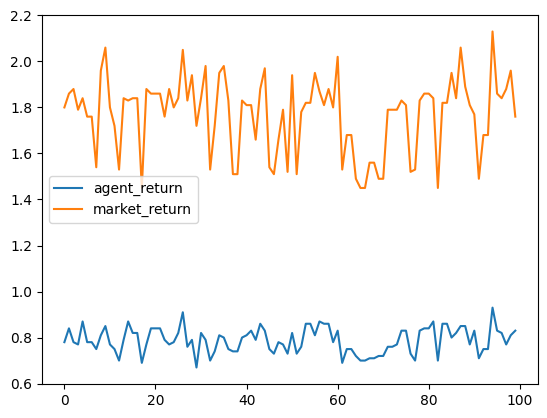

In [79]:

plt.plot(eval_profit,label='agent_return')
plt.plot(eval_market,label='market_return')
plt.legend()
np.mean(eval_profit),np.mean(eval_market)

In [80]:
eval_profit=[]
eval_market=[]
for i in tqdm( range(100)):
    obs,info=test_env.reset()
    action=None
    reward=0
    terminated = truncated = False

    while not terminated and not truncated:

        action,_,states = agent.compute_single_action(obs,explore=False)
        # action = train_env.action_space.sample()
        # print(action)
        next_obs, reward, terminated, truncated, info = test_env.step(action)

        obs=next_obs
    metrics=test_env.get_metrics()
    eval_market.append(float(metrics['Market Return'].replace('%','')))
    eval_profit.append(float(metrics['Portfolio Return'].replace('%','')))

    # info['portfolio_valuation']


  0%|          | 0/100 [00:00<?, ?it/s]


IndexError: list index out of range

In [ ]:

plt.plot(eval_profit,label='agent_return')
plt.plot(eval_market,label='market_return')
plt.legend()
np.mean(eval_profit),np.mean(eval_market)

In [ ]:
obs,info=test_env.reset()
action=None
reward=0
terminated = truncated = False


while not terminated and not truncated:

    action ,_,states= agent.compute_single_action(obs,explore=False)
    # action = train_env.action_space.sample()
    # print(action)
    next_obs, reward, terminated, truncated, info = test_env.step(action)

    obs=next_obs
info['reward'],info[ 'portfolio_valuation'],test_env.get_metrics()


